# MLOps Deployment Pipeline


## Overview

En este notebook, iremos paso a paso por un pipeline de MLOps para construir, entrenar, implementar y monitorear un modelo de regresión XGBoost que predice la tarifa de taxi esperada usando el [dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/) "New York City Taxi". Este pipeline presenta una estrategia de [implementación canaria](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/canary-deployment.html) con reversión en caso de error. La idea es poder entender cómo activar y monitorear el pipeline, inspeccionar el flujo de trabajo de entrenamiento, usar model monitor para configurar alertas y crear una implementación canary.

### Contenido

Este notebook contiene las siguientes secciones:

1. [Data Prep](#Data-Prep)
2. [Build](#Build)
3. [Train Model](#Train-Model)
4. [Deploy Dev](#Deploy-Dev)
5. [Deploy Prod](#Deploy-Prod)
6. [Monitor](#Monitor)
6. [Cleanup](#Cleanup)

### Arquitectura

El diagrama de arquitectura a continuación muestra todo el pipeline de MLOps a un alto nivel.

Usaremos la plantilla de CloudFormation proporcionada en este repositorio (`pipeline.yml`) para crear una demo en su propia cuenta de AWS. CloudFormation implementa varios recursos:
   
1. Una clave de cifrado administrada por el cliente en Amazon KMS para cifrar datos y artefactos.
1. Un secreto en Amazon Secrets Manager para almacenar de forma segura su token de acceso de GitHub.
1. Varias funciones de AWS IAM para que CloudFormation, SageMaker y otros servicios de AWS puedan realizar acciones en su cuenta de AWS, siguiendo el principio de [mínimo privilegio](https://docs.aws.amazon.com/IAM/latest/UserGuide/best-practices.html#grant-least-privilege)⇗.
1. Un servicio de mensajería en Amazon SNS para notificarle cuando CodeDeploy ha implementado correctamente la API y para recibir alertas de reentrenamiento y detección de desviaciones (registrarse para recibir estas notificaciones es opcional).
1. Dos reglas de eventos de Amazon CloudWatch: una que programa la ejecución del pipeline todos los meses y otra que activa la ejecución del pipeline cuando SageMaker Model Monitor detecta determinadas métricas.
1. Un notebook de Jupyter de Amazon SageMaker con el contenido de esta demo precargado.
1. Una instancia de AWS CodePipeline con varias etapas predefinidas.

Tomemos un momento para ver todos estos recursos ahora implementados en la cuenta.

![MLOps pipeline architecture](../docs/mlops-architecture.png)

En este notebook, trabajaremos a través de una instancia de CodePipeline creada por la plantilla de CloudFormation. Tiene varias etapas:

1. **Source** - El pipeline ya está configurado con dos fuentes. Si carga un nuevo conjunto de datos en una ubicación específica en el bucket de S3, esto activará la ejecución del pipeline. La fuente de Git puede ser GitHub o CodeCommit si no proporciona su token de acceso. Si envías código nuevo a tu repositorio, esto activará la ejecución del pipeline.
1. **Build** - En esta etapa, CodeBuild configurado por el archivo `model/buildspec.yml` ejecutará ` model/run.py` para generar plantillas de AWS CloudFormation para crear un Step Function (incluidos los recursos personalizados de AWS Lambda) y las plantillas de implementación utilizadas en las siguientes etapas según los conjuntos de datos y los hiperparámetros especificados para esta ejecución del pipeline.
1. **Train** El workflow de Step Functions creado en la etapa Build se ejecuta en esta etapa. El flujo de trabajo crea un baseline para el monitor de modelo usando un trabajo de procesamiento de SageMaker y entrena un modelo XGBoost en el dataset usando un job de entrenamiento de SageMaker.
1. **Deploy Dev** En esta etapa, una plantilla de CloudFormation creada en la etapa de Build (de `assets/deploy-model-dev.yml`) implementa un endpoint de desarrollo. Esto le permitirá ejecutar pruebas en el modelo y decidir si el modelo es de calidad suficiente para implementarlo en producción.
1. **Deploy Production** La etapa final del pipeline es la única etapa que no se ejecuta automáticamente tan pronto como se completa la etapa anterior. Espera a que un usuario apruebe manualmente el modelo que se implementó previamente en dev. Tan pronto como se aprueba el modelo, una plantilla de CloudFormation (empaquetada desde `assets/deploy-model-prod.yml` para incluir las funciones Lambda guardadas y cargadas como archivos ZIP en S3) implementa el endpoiny de producción. Configura el ajuste de escala automático y habilita la captura de datos. Crea un programa de monitoreo de modelos y establece alarmas de CloudWatch para ciertas métricas. También configura una instancia de AWS CodeDeploy que implementa un conjunto de funciones de AWS Lambda y un API Gateway para ubicarse frente al endpoint de SageMaker. Esta etapa puede hacer uso de la implementación de canary para cambiar de forma segura de un modelo antiguo a un modelo nuevo.

In [1]:
# Importamos las librerías necesarias
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker>=2.1.0<3" tqdm
!{sys.executable} -m pip install -qU "stepfunctions==2.0.0"
!{sys.executable} -m pip show sagemaker stepfunctions

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.21.44 which is incompatible.
Name: sagemaker
Version: 2.59.2
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages
Requires: numpy, boto3, pandas, smdebug-rulesconfig, protobuf, importlib-metadata, protobuf3-to-dict, pathos, attrs, google-pasta, packaging
Required-by: stepfunctions
---
Name: stepfunctions
Version: 2.0.0
Summary: Open source library for develping data science workflows on AWS Step Functions.
Home-page: https://github.com/aws/aws-step-functions-data-science-sdk-python
Author: Amazon Web Servic

Podría ser necesario reiniciar el kernel de Sagemaker para continuar.

## Data Prep

En esta sección del cuaderno, descargaremos el dataset disponible públicamente como preparación para cargarlo en S3.

### Descargar Dataset

Primero, descargamos una muestra del [dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/)⇗. This dataset contains information on trips taken by taxis and for-hire vehicles in New York City, including pick-up and drop-off times and locations, fares, distance traveled, and more. 

In [2]:
!aws s3 cp 's3://nyc-tlc/trip data/green_tripdata_2018-02.csv' 'nyc-tlc.csv'

download: s3://nyc-tlc/trip data/green_tripdata_2018-02.csv to ./nyc-tlc.csv


Cargamos el dataset en un dataframe de pandas, teniendo cuidado de parsear correctamente las fechas.

In [3]:
import pandas as pd

parse_dates= ['lpep_dropoff_datetime', 'lpep_pickup_datetime']
trip_df = pd.read_csv('nyc-tlc.csv', parse_dates=parse_dates)

trip_df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2018-02-01 00:39:38,2018-02-01 00:39:41,N,5,97,65,1,0.00,20.0,0.0,0.0,3.00,0.0,NaN,0.0,23.00,1,2
1,2,2018-02-01 00:58:28,2018-02-01 01:05:35,N,1,256,80,5,1.60,7.5,0.5,0.5,0.88,0.0,NaN,0.3,9.68,1,1
2,2,2018-02-01 00:56:05,2018-02-01 01:18:54,N,1,25,95,1,9.60,28.5,0.5,0.5,5.96,0.0,NaN,0.3,35.76,1,1
3,2,2018-02-01 00:12:40,2018-02-01 00:15:50,N,1,61,61,1,0.73,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,2,1
4,2,2018-02-01 00:45:18,2018-02-01 00:51:56,N,1,65,17,2,1.87,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1


### Data manipulation

En lugar de usar las fechas y horas de recojo y llegada, usaremos estos features para calcular el tiempo total del viaje en minutos, los cuáles serám fáciles de trabajar con nuestor modelo.

In [4]:
trip_df['duration_minutes'] = (trip_df['lpep_dropoff_datetime'] - trip_df['lpep_pickup_datetime']).dt.seconds/60

El dataset contiene un monton de columnas que no necesitamos, vamos a seleccionar una muestra de las columnas para nuestro modelo de ML. Mantenemos sólo `total_amount` (fare), `duration_minutes`, `passenger_count`, y `trip_distance`.

In [5]:
cols = ['total_amount', 'duration_minutes', 'passenger_count', 'trip_distance']
data_df = trip_df[cols]
print(data_df.shape)
data_df.head()

(769940, 4)


,total_amount,duration_minutes,passenger_count,trip_distance
0,23.00,0.050000,1,0.00
1,9.68,7.116667,5,1.60
2,35.76,22.816667,1,9.60
3,5.80,3.166667,1,0.73
4,9.30,6.633333,2,1.87


Generamos algunas estadísticas del dataset para entender la calidad.

In [6]:
data_df.describe()

,total_amount,duration_minutes,passenger_count,trip_distance
count,769940.000000,769940.000000,769940.000000,769940.000000
mean,14.156694,19.536958,1.356391,2.725387
std,10.707214,93.847137,1.033778,2.882936
min,-400.000000,0.000000,0.000000,0.000000
25%,7.800000,6.016667,1.000000,1.000000
50%,11.150000,10.116667,1.000000,1.750000
75%,17.000000,16.850000,1.000000,3.370000
max,2626.300000,1439.883333,9.000000,120.470000


La tabla de arriba muestra algunos outliers, por ejemplo -400 o 2626 como tarifa, o 0 pasajeros. Hay muchos métodos inteligemtes para identificar y remover outliers pero la limpieza de datos no es el foco de este notebook, asi que solo removemos los outliers configurando valores mínimos y máximos los cuáles parecen más razonables. Eliminando los outliers obtenermos 754,671 filas en el dataset final.

In [7]:
data_df = data_df[(data_df.total_amount > 0) & (data_df.total_amount < 200) & 
                  (data_df.duration_minutes > 0) & (data_df.duration_minutes < 120) & 
                  (data_df.trip_distance > 0) & (data_df.trip_distance < 121) & 
                  (data_df.passenger_count > 0)].dropna()
print(data_df.shape)

(754671, 4)


### Data visualization

Dado que este notebook creará un modelo de regresión para el dataset, es una buena idea comprobar si existe alguna correlación entre las variables de nuestros datos. Utilizamos diagramas de dispersión en una muestra de los datos para comparar la distancia del viaje con la duración en minutos y la cantidad total (tarifa) con la duración en minutos.

<AxesSubplot:xlabel='duration_minutes', ylabel='trip_distance'>

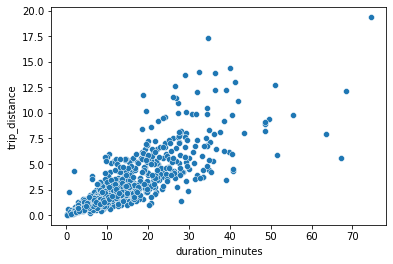

In [8]:
import seaborn as sns 

sample_df = data_df.sample(1000)
sns.scatterplot(data=sample_df, x='duration_minutes', y='trip_distance')

<AxesSubplot:xlabel='duration_minutes', ylabel='total_amount'>

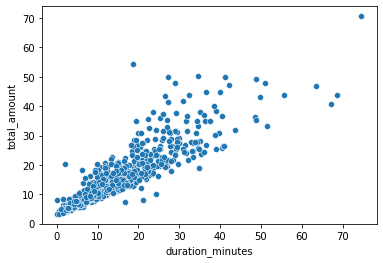

In [9]:
sns.scatterplot(data=sample_df, x='duration_minutes', y='total_amount')

Estos gráficos de dispersión se ven bien y muestran al menos alguna correlación entre nuestras variables.

### Data splitting and saving

Ahora estamos listos para dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba.

In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.05, random_state=42)

# Reset the index for our test dataframe
test_df.reset_index(inplace=True, drop=True)

print('Size of\n train: {},\n val: {},\n test: {} '.format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

Size of
 train: 603736,
 val: 143388,
 test: 7547 


Guardamos los archivos de entrenamiento, validación y prueba como CSV localmente en esta instancia de notebook. Observe que guardamos el archivo de entrenamiento dos veces: una como archivo de datos de entrenamiento y otra como archivo de datos de referencia. [SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) utilizará el archivo de datos de referencia para detectar la data drift (deriva de datos). La deriva de datos ocurre cuando la naturaleza estadística de los datos que recibe su modelo mientras está en producción se aleja de la naturaleza de los datos de línea base en los que fue entrenado, lo que significa que el modelo comienza a perder precisión en sus predicciones.

In [11]:
train_cols = ['total_amount', 'duration_minutes','passenger_count','trip_distance']
train_df.to_csv('train.csv', index=False, header=False)
val_df.to_csv('validation.csv', index=False, header=False)
test_df.to_csv('test.csv', index=False, header=False)

# Save test and baseline with headers
train_df.to_csv('baseline.csv', index=False, header=True)

Ahora cargamos estos archivos CSV en el backet SageMaker S3 predeterminado.

In [12]:
import sagemaker

# Get the session and default bucket
session = sagemaker.session.Session()
bucket = session.default_bucket()

# Specify data prefix and version
prefix = 'nyc-tlc/v1'

s3_train_uri = session.upload_data('train.csv', bucket, prefix + '/data/training')
s3_val_uri = session.upload_data('validation.csv', bucket, prefix + '/data/validation')
s3_test_uri = session.upload_data('test.csv', bucket, prefix + '/data/test')
s3_baseline_uri = session.upload_data('baseline.csv', bucket, prefix + '/data/baseline')

Usaremos los datasets que hemos preparado y guardado en esta sección para activar el pipeline para entrenar e implementar un modelo en la siguiente sección.

## Build

Si vamos a CodePipeline, notaremos que la etapa "Source" está inicialmente en un estado "Fallido". Esto sucede porque el conjunto de datos, que es una de las fuentes que pueden desencadenar el pipeline, aún no se ha cargado en la ubicación S3 esperada.

![Failed code pipeline](../docs/pipeline_failed.png)

### Trigger Build
 
En esta sección, iniciaremos un pipeline de implementación y compilación de modelos empaquetando los datasets que preparamos en la sección anterior y cargándolos en la ubicación de origen de S3 que activa la instancia de CodePipeline creada.

Primero, importamos algunas librerías y cargaremos algunas variables de entorno que se van a necesitar. Estas variables de entorno se han establecido a través de un script de [lifecycle configuration](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-lifecycle-config.html)⇗ adjunto a este notebook.

In [14]:
import boto3
from botocore.exceptions import ClientError
import os
import time

region = boto3.Session().region_name
artifact_bucket = os.environ['ARTIFACT_BUCKET']
pipeline_name = os.environ['PIPELINE_NAME']
model_name = os.environ['MODEL_NAME']
workflow_pipeline_arn = os.environ['WORKFLOW_PIPELINE_ARN']

print('region: {}'.format(region))
print('artifact bucket: {}'.format(artifact_bucket))
print('pipeline: {}'.format(pipeline_name))
print('model name: {}'.format(model_name))
print('workflow: {}'.format(workflow_pipeline_arn))

region: us-east-1
artifact bucket: mlops-nyctaxi-artifact-us-east-1-962542737140
pipeline: nyctaxi
model name: nyctaxi
workflow: arn:aws:states:us-east-1:962542737140:stateMachine:nyctaxi


From the AWS CodePipeline [documentation](https://docs.aws.amazon.com/codepipeline/latest/userguide/tutorials-simple-s3.html)⇗:

> Cuando Amazon S3 es el proveedor de origen de un pipeline, puede comprimir un archivo o archivos de origen en un solo .zip y cargar el .zip en el backet de origen. También puede cargar un solo archivo descomprimido; sin embargo, las acciones posteriores que esperan un archivo .zip fallarán.

Para entrenar un modelo, necesitaremos varios datasets (entrenamiento, validación y prueba) junto con un archivo que especifica los hiperparámetros. En este ejemplo, crearemos un archivo JSON que contiene las ubicaciones de los datasets en S3 y un archivo JSON que contiene los valores de los hiperparámetros. Luego, comprimiremos ambos archivos en un zip que se utilizará como entrada para la ejecución del pipeline.

In [15]:
from io import BytesIO
import zipfile
import json

input_data = {
    'TrainingUri': s3_train_uri,
    'ValidationUri': s3_val_uri,
    'TestUri': s3_test_uri,
    'BaselineUri': s3_baseline_uri
}

hyperparameters = {
    'num_round': 50
}

zip_buffer = BytesIO()
with zipfile.ZipFile(zip_buffer, 'a') as zf:
    zf.writestr('inputData.json', json.dumps(input_data))
    zf.writestr('hyperparameters.json', json.dumps(hyperparameters))
zip_buffer.seek(0)

data_source_key = '{}/data-source.zip'.format(pipeline_name)

Ahora cargamos el zip en el backet de artefactos S3; esta acción activará el pipeline para entrenar e implementar un modelo.

In [16]:
s3 = boto3.client('s3')
s3.put_object(Bucket=artifact_bucket, Key=data_source_key, Body=bytearray(zip_buffer.read()))

{'ResponseMetadata': {'RequestId': 'AZ03A41GCC21GEN3',
  'HostId': 'SGq7gPosDio4qbJg21crTl9kWpSODP20lL3Eg1TwfU8nmBJjvp8a6T4j5S+OurndyRf1HXsfydE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'SGq7gPosDio4qbJg21crTl9kWpSODP20lL3Eg1TwfU8nmBJjvp8a6T4j5S+OurndyRf1HXsfydE=',
   'x-amz-request-id': 'AZ03A41GCC21GEN3',
   'date': 'Sat, 18 Sep 2021 03:05:05 GMT',
   'x-amz-version-id': 'TqfszOmVfvNFjCVgaND_Rjk4280XWcKS',
   'etag': '"7e42d8857e8b437d5513732ccc387602"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"7e42d8857e8b437d5513732ccc387602"',
 'VersionId': 'TqfszOmVfvNFjCVgaND_Rjk4280XWcKS'}

Hacemos clic en el enlace a continuación para abrir la consola de AWS en Code Pipeline si no la tiene abierta en otra pestaña.

<div class="alert alert-block alert-info">
    Tip: Es posible que deba esperar un minuto para que la etapa DataSource se ponga verde. La página se actualizará automáticamente.
</div>

![Source Green](../docs/datasource-after.png)

In [17]:
from IPython.core.display import HTML

HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codepipeline/pipelines/{1}/view?region={0}">Code Pipeline</a>'.format(region, pipeline_name))

### Inspect Build Logs

Una vez que se esté ejecutando la etapa de compilación o Build, verá que el trabajo de AWS CodeBuild se vuelve azul con un estado de **En progreso**.

![Failed code pipeline](../docs/codebuild-inprogress.png)

Puede hacer clic en el enlace **Detalles** que se muestra en la interfaz de usuario de CodePipeline o hacer clic en el enlace a continuación para ir directamente a los registros de CodeBuild.

<div class="alert alert-block alert-info">
    Tip: Es posible que deba esperar unos segundos para que el pipeline pase al estado activo (azul) y para que comience la compilación.
</div>

In [18]:
codepipeline = boto3.client('codepipeline')

def get_pipeline_stage(pipeline_name, stage_name):
    response = codepipeline.get_pipeline_state(name=pipeline_name)
    for stage in response['stageStates']:
        if stage['stageName'] == stage_name:
            return stage

# Get last execution id
build_stage = get_pipeline_stage(pipeline_name, 'Build')    
if not 'latestExecution' in build_stage:
    raise(Exception('Please wait.  Build not started'))

build_url = build_stage['actionStates'][0]['latestExecution']['externalExecutionUrl']

# Out a link to the code build logs
HTML('<a target="_blank" href="{0}">Code Build Logs</a>'.format(build_url))

El proceso de AWS CodeBuild es responsable de crear una serie de plantillas de AWS CloudFormation que exploraremos con más detalle en la siguiente sección. Dos de estas plantillas se utilizan para configurar el paso **Entrenar** mediante la creación de un workflow de AWS Step Functions y las funciones personalizadas de AWS Lambda que se utilizan en este workflow.

## Train Model

### Inspect Training Job

Esperamos hasta que el pípeline haya comenzado a ejecutar el paso de entrenamiento (vea la captura de pantalla) antes de continuar con las siguientes celdas de este noteboook.

![Training in progress](../docs/train-in-progress.png)

Cuando el pipeline ha comenzado a ejecutar el paso de entrenamiento, puede hacer clic en el enlace **Detalles** que se muestra en la interfaz de usuario de CodePipeline (vea la captura de pantalla anterior) para ver el flujo de trabajo de Step Functions que está ejecutando el trabajo de entrenamiento.

Alternativamente, puede hacer clic en el enlace Workflow de la salida de la celda a continuación una vez que esté disponible.

In [19]:
from stepfunctions.workflow import Workflow
while True:
    try:
        workflow = Workflow.attach(workflow_pipeline_arn)
        break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

workflow

Workflow(name='nyctaxi', role='arn:aws:iam::962542737140:role/mlops-nyctaxi-sfn-execution-role', state_machine_arn='arn:aws:states:us-east-1:962542737140:stateMachine:nyctaxi')

O simplemente ejecute la celda a continuación para mostrar el workflow de Step Functions y vuelva a ejecutarlo después de unos minutos para ver el progreso.

In [24]:
executions = workflow.list_executions()
if not executions:
    raise(Exception('Please wait.  Training not started'))
    
executions[0].render_progress()

### Revisamos el script de Build

Mientras esperamos a que se complete el trabajo de entrenamiento, revisemos el código `run.py` que fue utilizado por el proceso de AWS CodeBuild.

Este script toma todos los parámetros de entrada, incluidas las ubicaciones de los datasets y los hiperparámetros que guardó en archivos JSON anteriormente en este notebook, y los usa para generar las plantillas que el pipeline necesita para ejecutar el job de entrenamiento. *No* crea la instancia de Step Functions real; solo genera las plantillas que definen el workflow de Step Functions, así como las plantillas de entrada de CloudFormation que CodePipeline usa para crear la instancia de Step Functions.

Paso a paso, el script hace lo siguiente:

1. Recopila todos los parámetros de entrada que necesita para generar las plantillas. Esto incluye información sobre el contenedor de entorno necesario para ejecutar el job de entrenamiento, las ubicaciones de los datos de entrada y salida, los roles de IAM necesarios para varios componentes, las claves de cifrado y más. Luego configura algunos parámetros básicos como la región de AWS y los nombres de las funciones.
1. Si los parámetros de entrada especifican un contenedor de entorno almacenado en ECR, obtiene ese contenedor. De lo contrario, obtiene el URI del contenedor del entorno administrado de AWS necesario para el job de entrenamiento.
1. Lee el archivo JSON de datos de entrada que generó anteriormente en este notebook (y que se incluyó en la fuente zip para el pipeline), obteniendo así las ubicaciones de entrenamiento, validación y los archivos de datos baseline. Luego, formatea más parámetros que se necesitarán más adelante en el script, incluidos los ID de versión y las ubicaciones de los datos de salida.
1. Lee el archivo JSON de hiperparámetro que generó anteriormente en este notebook.
1. Define el workflow de Step Functions, comenzando con el esquema de entrada, seguido de cada paso del flujo de trabajo (es decir, crear experimento, trabajo de referencia, trabajo de entrenamiento) y finalmente combina esos pasos en un gráfico de flujo de trabajo.
1. El gráfico del flujo de trabajo se guarda en un archivo, junto con un archivo que contiene todos los parámetros de entrada guardados de acuerdo con el esquema definido en el flujo de trabajo.
1. Guarda los parámetros en un archivo que CloudFormation utilizará para crear una instancia de workflow de Step Functions.

In [22]:
!pygmentize ../model/run.py

import argparse
import json
import os
import sys
import time

import boto3

import sagemaker
from sagemaker.image_uris import retrieve
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker.model_monitor.dataset_format import DatasetFormat

import stepfunctions
from stepfunctions import steps
from stepfunctions.inputs import ExecutionInput
from stepfunctions.workflow import Workflow


def create_experiment_step(create_experiment_function_name):
    create_experiment_step = steps.compute.LambdaStep(
        "Create Experiment",
        parameters={
            "FunctionName": create_experiment_function_name,
            "Payload": {"ExperimentName.$": "$.ExperimentName", "TrialName.$": "$.TrialName",},
        },
        result_path="$.CreateTrialResults",
    )
    return create_experiment_step


def create_baseline_step(input_data, execution_input, region, role):
    # Define the enviornment
    dataset_format = DatasetFormat.csv()
    env = {
   

### Customize Workflow (Optional)

Si está interesado en personalizar el workflow utilizado en el script de compilación (build), almacene los `input_data` que se utilizarán en el notebook local [workflow.ipynb](workflow.ipynb). El notebook "workflow" se puede utilizar para experimentar con el flujo de trabajo de Step Functions y las definiciones del job de entrenamiento para su modelo.

In [25]:
%store input_data

Stored 'input_data' (dict)


### Training Analytics

Una vez que se completan los trabajos de entrenamiento y del baseline (lo que significa que se muestran en color verde en el workflow de Step Functions, esto toma alrededor de 5 minutos), puede inspeccionar las métricas del experimento. El siguiente código mostrará todos los experimentos en una tabla. Tenga en cuenta que el trabajo de procesamiento del baseline (línea base) no tendrá métricas de RMSE: calcula las métricas en función de los datos de entrenamiento, pero no entrena un modelo de machine learning.

Se puede [explorar los resultados del baseline](#Explorar-Baseline) después. <a id="validation-results"></a>

In [26]:
from sagemaker import analytics
experiment_name = 'mlops-{}'.format(model_name)
model_analytics = analytics.ExperimentAnalytics(experiment_name=experiment_name)
analytics_df = model_analytics.dataframe()

if (analytics_df.shape[0] == 0):
    raise(Exception('Please wait.  No training or baseline jobs'))

pd.set_option('display.max_colwidth', 100) # Increase column width to show full copmontent name
cols = ['TrialComponentName', 'DisplayName', 'SageMaker.InstanceType', 
        'train:rmse - Last', 'validation:rmse - Last'] # return the last rmse for training and validation
analytics_df[analytics_df.columns & cols].head(2)

,TrialComponentName,DisplayName,SageMaker.InstanceType,train:rmse - Last,validation:rmse - Last
0,mlops-nyctaxi-pbl-8088d44e-e8ce-4936-a0c4-97e41805f817-aws-processing-job,Baseline,ml.m5.xlarge,NaN,NaN
1,mlops-nyctaxi-8088d44e-e8ce-4936-a0c4-97e41805f817-aws-training-job,Training,ml.m4.xlarge,2.69577,2.74035


## Deploy Dev

### Test Dev Deployment

Cuando el pipeline ha terminado de entrenar un modelo, pasa automáticamente al siguiente paso, donde el modelo se implementa como un endpoint de SageMaker. Este endpoint es parte de la implementación de desarrollo, por lo tanto, en esta sección, ejecutaremos algunas pruebas en el endpoint para decidir si deseamos implementar este modelo en producción.

Primero, ejecutamos la celda a continuación para buscar el nombre del SageMaker Endpoint.

In [27]:
codepipeline = boto3.client('codepipeline')

deploy_dev = get_pipeline_stage(pipeline_name, 'DeployDev')
if not 'latestExecution' in deploy_dev:
    raise(Exception('Please wait.  Deploy dev not started'))
    
execution_id = deploy_dev['latestExecution']['pipelineExecutionId']
dev_endpoint_name = 'mlops-{}-dev-{}'.format(model_name, execution_id)

print('endpoint name: {}'.format(dev_endpoint_name))

endpoint name: mlops-nyctaxi-dev-8088d44e-e8ce-4936-a0c4-97e41805f817


Si pasamos por la sección anterior muy rápidamente, deberemos esperar hasta que el endpoint de desarrollo se haya implementado con éxito y el pipeline esté esperando la aprobación para implementar en producción (ver captura de pantalla). SageMaker puede tardar hasta 10 minutos en crear un punto final.

![Deploying dev endpoint in code pipeline](../docs/dev-deploy-ready.png)

Alternativamente, ejecutaremos el código a continuación para verificar el estado del endpoint. Esperamos hasta que el estado sea 'InService'.

In [28]:
sm = boto3.client('sagemaker')

while True:
    try:
        response = sm.describe_endpoint(EndpointName=dev_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        if response['EndpointStatus'] == 'InService':
            break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint sta

Ahora que el endpoint está listo, escribamos un código para ejecutar los datos de prueba (que separamos aneriormente del conjunto de datos y se guardó en un archivo al comienzo de este notebook) a través del endpoint de inferencia. El siguiente código es compatible con la v1 y la v2 del SDK de SageMaker, pero recomendamos utilizar la v2 del SDK en todos sus proyectos futuros.

In [29]:
import numpy as np
from tqdm import tqdm

try:
    # Support SageMaker v2 SDK: https://sagemaker.readthedocs.io/en/stable/v2.html
    from sagemaker.predictor import Predictor
    from sagemaker.serializers import CSVSerializer
    def get_predictor(endpoint_name):
        xgb_predictor = Predictor(endpoint_name)
        xgb_predictor.serializer = CSVSerializer()
        return xgb_predictor
except:
    # Fallback to SageMaker v1.70 SDK
    from sagemaker.predictor import RealTimePredictor, csv_serializer
    def get_predictor(endpoint_name):
        xgb_predictor = RealTimePredictor(endpoint_name)
        xgb_predictor.content_type = 'text/csv'
        xgb_predictor.serializer = csv_serializer
        return xgb_predictor

def predict(predictor, data, rows=500):
    split_array = np.array_split(data, round(data.shape[0] / float(rows)))
    predictions = ''
    for array in tqdm(split_array):
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

Ahora usamos la función `predecir`, que se definió en el código anterior, para ejecutar los datos de prueba a través del endpoint y generar las predicciones.

In [30]:
dev_predictor = get_predictor(dev_endpoint_name)
predictions = predict(dev_predictor, test_df[test_df.columns[1:]].values)

100%|██████████| 15/15 [00:00<00:00, 29.15it/s]


A continuación, cargamos las predicciones en un dataframe y las unimos con los datos de prueba. Luego, calculamos el error absoluto como la diferencia entre la tarifa real del taxi y la tarifa prevista del taxi. Mostramos los resultados en una tabla, ordenados por los valores de error absoluto más altos.

In [31]:
pred_df = pd.DataFrame({'total_amount_predictions': predictions })
pred_df = test_df.join(pred_df) # Join on all
pred_df['error'] = abs(pred_df['total_amount']-pred_df['total_amount_predictions'])

pred_df.sort_values('error', ascending=False).head()

,total_amount,duration_minutes,passenger_count,trip_distance,total_amount_predictions,error
6055,95.8,15.000000,5,3.50,16.288776,79.511224
4847,85.0,43.683333,8,4.54,30.932413,54.067587
5174,52.8,0.616667,1,0.20,6.562790,46.237210
4842,52.8,0.416667,1,0.02,7.555273,45.244727
3211,52.8,6.333333,1,0.90,7.804719,44.995281


En esta tabla, observamos que algunas distancias de viaje cortas tienen grandes errores porque la tarifa baja prevista no coincide con la tarifa real alta. Esto podría ser el resultado de una generosa propina que no hemos incluido en este conjunto de datos.

También puede analizar los resultados trazando el error absoluto para visualizar valores atípicos. En este gráfico, vemos que la mayoría de los valores atípicos son casos en los que el modelo predijo una tarifa mucho más baja que la tarifa real. Solo hay unos pocos valores atípicos en los que el modelo predijo una tarifa más alta que la tarifa real.

<AxesSubplot:xlabel='total_amount_predictions', ylabel='total_amount'>

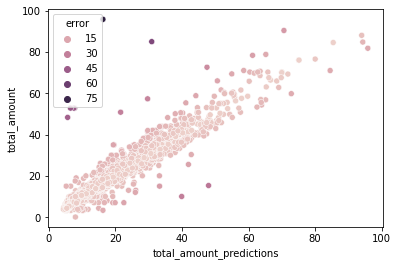

In [32]:
sns.scatterplot(data=pred_df, x='total_amount_predictions', y='total_amount', hue='error')

Si desea una medida general de calidad para el modelo, puede calcular el error cuadrático medio (RMSE) de las tarifas previstas en comparación con las tarifas reales. Comparamos esto con [results calculated on the validation set](#validation-results) al final de la sección 'Inspect Training Job'.

In [33]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def rmse(pred_df):
    return sqrt(mean_squared_error(pred_df['total_amount'], pred_df['total_amount_predictions']))

print('RMSE: {}'.format(rmse(pred_df)))

RMSE: 2.7133481502864263


## Deploy Prod

### Approve Deployment to Production

Si estamos satisfecho con los resultados del modelo, puede seguir adelante y aprobar el modelo que se implementará en producción. Puede hacerlo haciendo clic en el botón **Revisar** en la interfaz de usuario de CodePipeline, dejando un comentario para explicar por qué aprueba este modelo y haciendo clic en **Aprobar**.

Alternativamente, podemos crear un widget de Jupyter que (cuando está habilitado) le permite comentar y aprobar el modelo directamente desde este notebook. Ejecute la celda a continuación para ver esto en acción.

In [35]:
import ipywidgets as widgets

def on_click(obj):
    result = { 'summary': approval_text.value, 'status': obj.description }
    response = codepipeline.put_approval_result(
      pipelineName=pipeline_name,
      stageName='DeployDev',
      actionName='ApproveDeploy',
      result=result,
      token=approval_action['token']
    )
    button_box.close()
    print(result)
    
# Create the widget if we are ready for approval
deploy_dev = get_pipeline_stage(pipeline_name, 'DeployDev')
if not 'latestExecution' in deploy_dev['actionStates'][-1]:
    raise(Exception('Please wait.  Deploy dev not complete'))

approval_action = deploy_dev['actionStates'][-1]['latestExecution']
if approval_action['status'] == 'Succeeded':
    print('Dev approved: {}'.format(approval_action['summary']))
elif 'token' in approval_action:
    approval_text = widgets.Text(placeholder='Optional approval message')   
    approve_btn = widgets.Button(description="Approved", button_style='success', icon='check')
    reject_btn = widgets.Button(description="Rejected", button_style='danger', icon='close')
    approve_btn.on_click(on_click)
    reject_btn.on_click(on_click)
    button_box = widgets.HBox([approval_text, approve_btn, reject_btn])
    display(button_box)
else:
    raise(Exception('Please wait. No dev approval'))

{'summary': '', 'status': 'Approved'}


### Test Production Deployment

Aproximadamente un minuto después de aprobar la implementación del modelo, debería ver que el pipeline comienza en el paso final: implementar el modelo en producción. En esta sección, comprobaremos el estado de implementación y probaremos el endpoint de producción después de que se haya implementado.

![Deploy production endpoint in code pipeline](../docs/deploy-production.png)

Este paso del pipeline utiliza CloudFormation para implementar una serie de recursos en su nombre. En particular, crea:

1. Endpoint de sagemaker listo para producción , con [data capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html)⇗  (used by SageMaker Model Monitor) y [autoscaling](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html)⇗ enabled.
1. Un [model monitoring schedule](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-scheduling.html)⇗ que envía los resultados a de CloudWatch Metrics, junto con un [CloudWatch Alarm](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/AlarmThatSendsEmail.html)⇗ que le notificará cuando ocurra una infracción.
1. Una instancia de CodeDeploy que crea una aplicación simple mediante la implementación de API Gateway, tres funciones de Lambda y una alarma para notificar el éxito o el fracaso de esta implementación. El código para las funciones de Lambda se puede encontrar en `api/app.py`,` api/pre_traffic_hook.py` y `api/ post_traffic_hook.py`. Estas funciones actualizan el endpoint para permitir la captura de datos, formatear y enviar el tráfico entrante al endpoint de SageMaker y capturar los registros de datos.

![Components of production deployment](../docs/cloud-formation.png)

Veamos cómo avanza la implementación. Utilice el siguiente código para obtener el ID de ejecución del paso de implementación. Luego, genere una tabla que enumere los recursos creados por el stack de CloudFormation y su estado de creación. Puede volver a ejecutar la celda después de unos minutos para ver cómo avanzan los pasos.

In [36]:
deploy_prd = get_pipeline_stage(pipeline_name, 'DeployPrd')
if not 'latestExecution' in deploy_prd or not 'latestExecution' in deploy_prd['actionStates'][0]:
    raise(Exception('Please wait.  Deploy prd not started'))
    
execution_id = deploy_prd['latestExecution']['pipelineExecutionId']

In [38]:
from datetime import datetime, timedelta
from dateutil.tz import tzlocal

def get_event_dataframe(events):
    stack_cols = ['LogicalResourceId', 'ResourceStatus', 'ResourceStatusReason', 'Timestamp']
    stack_event_df = pd.DataFrame(events)[stack_cols].fillna('')
    stack_event_df['TimeAgo'] = (datetime.now(tzlocal())-stack_event_df['Timestamp'])
    return stack_event_df.drop('Timestamp', axis=1)

cfn = boto3.client('cloudformation')

stack_name = stack_name='{}-deploy-prd'.format(pipeline_name)
print('stack name: {}'.format(stack_name))

# Get latest stack events
while True:
    try:
        response = cfn.describe_stack_events(StackName=stack_name)
        break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)
    
get_event_dataframe(response['StackEvents']).head()

stack name: nyctaxi-deploy-prd


,LogicalResourceId,ResourceStatus,ResourceStatusReason,TimeAgo
0,ApiFunctionRole,CREATE_COMPLETE,,0 days 00:00:02.563018
1,CodeDeployServiceRole,CREATE_COMPLETE,,0 days 00:00:04.082018
2,Endpoint,CREATE_IN_PROGRESS,Resource creation Initiated,0 days 00:00:05.467018
3,Endpoint,CREATE_IN_PROGRESS,,0 days 00:00:07.844018
4,EndpointConfig,CREATE_COMPLETE,,0 days 00:00:09.943018


El recurso que más nos interesa es el endpoint. Esto demora una promedio de 10 minutos en implementarse. Mientras tanto, puede echar un vistazo al código Python utilizado para la aplicación. 

`App.py` es el principal punto de entrada que invoca el endpoint de Amazon SageMaker. Devuelve resultados junto con un encabezado personalizado para el endpoint que invocamos.

In [39]:
!pygmentize ../api/app.py

import json
import logging
import os

import boto3
from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

sm_runtime = boto3.client("sagemaker-runtime")


def lambda_handler(event, context):
    logger.debug("event %s", json.dumps(event))
    endpoint_name = os.environ["ENDPOINT_NAME"]
    logger.info("api for endpoint %s", endpoint_name)

    # Get posted body and content type
    content_type = event["headers"].get("Content-Type", "text/csv")
    custom_attributes = event["headers"].get("X-Amzn-SageMaker-Custom-Attributes", "")
    if content_type.startswith("text/csv"):
        payload = event["body"]
    elif content_type.startswith("application/json"):
        payload = json.loads(event["body"])
    else:
        message = "bad content type: {}".format(content_type)
        logger.error()
        return {"statusCode": 500, "message": message}

    logger.info("content type: %s size: %d", content_type, len(payload))

    tr

El lambda `pre_traffic_hook.py` lambda se invoca antes de la implementación y confirma que el endpoint tiene habilitada la captura de datos.

In [40]:
!pygmentize ../api/pre_traffic_hook.py

import json
import logging
import os

import boto3
from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

sm = boto3.client("sagemaker")
cd = boto3.client("codedeploy")


def lambda_handler(event, context):
    logger.debug("event %s", json.dumps(event))
    endpoint_name = os.environ["ENDPOINT_NAME"]
    logger.info("pre traffic for endpoint %s", endpoint_name)

    error_message = None
    try:
        # Update endpoint to enable data capture
        response = sm.describe_endpoint(EndpointName=endpoint_name)
        status = response["EndpointStatus"]
        if status != "InService":
            error_message = "SageMaker endpoint: {} status: {} not InService".format(
                endpoint_name, status
            )
        else:
            # Validate that endpoint config has data capture enabled
            endpoint_config_name = response["EndpointConfigName"]
            response = sm.describe_endpoint_config(
       

El lambda `post_traffic_hook.py` se invoca para realizar las comprobaciones finales, en este caso para verificar que hemos recibido los datos de log de la captura de datos.

In [41]:
!pygmentize ../api/post_traffic_hook.py

import json
import logging
import os

import boto3
from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

sm = boto3.client("sagemaker")
s3 = boto3.client("s3")
cd = boto3.client("codedeploy")


def get_bucket_prefix(url):
    try:
        from urllib.parse import urlparse
    except ImportError:
        from urlparse import urlparse
    a = urlparse(url)
    return a.netloc, a.path.lstrip("/") + "/"


def lambda_handler(event, context):
    logger.debug("event %s", json.dumps(event))
    endpoint_name = os.environ["ENDPOINT_NAME"]
    logger.info("post traffic for endpoint: %s", endpoint_name)
    data_capture_uri = os.environ.get("DATA_CAPTURE_URI", "")
    logger.info("data capture uri: %s", data_capture_uri)

    error_message = None
    try:
        if data_capture_uri:
            # List objects under data capture logs director
            bucket, prefix = get_bucket_prefix(data_capture_uri)
            contents = s3.list

Utilizamos el siguiente código para obtener el nombre del endpoint, luego ejecute un bucle para esperar a que el endpoint se implemente por completo. Necesitamos que el estado sea 'En servicio'.

In [42]:
prd_endpoint_name='mlops-{}-prd-{}'.format(model_name, execution_id)
print('prod endpoint: {}'.format(prd_endpoint_name))

prod endpoint: mlops-nyctaxi-prd-8088d44e-e8ce-4936-a0c4-97e41805f817


In [43]:
sm = boto3.client('sagemaker')

while True:
    try:
        response = sm.describe_endpoint(EndpointName=prd_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        # Wait until the endpoint is in service with data capture enabled
        if response['EndpointStatus'] == 'InService' \
            and 'DataCaptureConfig' in response \
            and response['DataCaptureConfig']['EnableCapture']:
            break
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint sta

Cuando el estado del endpoint es 'InService', puede continuar. Anteriormente en este cuaderno, creamos un código para enviar datos al endpoint de desarrollo. Reutilice este código ahora para enviar una muestra de los datos de prueba al endpoint de producción. Dado que la captura de datos está habilitada en este punto final, desea enviar registros individuales a la vez, de modo que el monitor del modelo pueda asignar estos registros a la línea de base.

Más tarde haremos uso de [inspect the model monitor](#Inspect-Model-Monitor). For now, just check if you can send data to the endpoint and receive predictions in return. Por ahora, solo verifique si puede enviar datos al punto final y recibir predicciones a cambio.

In [44]:
prd_predictor = get_predictor(prd_endpoint_name)
sample_values = test_df[test_df.columns[1:]].sample(100).values
predictions = predict(prd_predictor, sample_values, rows=1)
predictions

100%|██████████| 100/100 [00:01<00:00, 59.50it/s]


array([ 6.14452076, 15.4426012 , 10.3297205 ,  7.12844515, 19.27596855,
       19.91897964,  9.53039074,  9.57470798, 22.59270859, 21.34565926,
       21.22851562,  8.36337757, 47.51456833,  5.96635151,  6.58925724,
       13.89829922, 24.90311623,  6.86523151,  7.50823116,  9.46011925,
       16.64295387,  9.94624329, 10.34152603,  6.30059481,  8.85488701,
       10.77643681, 30.67555046,  8.6021204 ,  9.65930843,  9.22501183,
       48.31124878,  7.58374119, 45.55388641, 40.2144165 , 16.49039841,
       30.03656387, 10.01031303, 12.08086205,  6.50738144, 17.93732262,
        6.40625143, 11.89199352, 33.6006012 , 21.85989189, 10.50108242,
       10.44023705, 19.37092209, 12.61988068,  5.74905014, 16.21562195,
        5.81643009, 14.03055   ,  9.39214993, 10.56586552,  6.44927883,
       11.86130333,  7.76424742,  9.43459606, 22.52345085,  5.30188608,
       22.04075241, 22.84882545, 14.65772057,  7.2268877 , 14.94792938,
        8.28263664, 62.50871658,  9.53837681, 22.84793282,  6.81

### Test REST API

Aunque ya probó el endpoint de SageMaker en la sección anterior, también es una buena idea probar la aplicación creada con API Gateway.

![Traffic shift between endpoints](../docs/lambda-deploy-create.png)

Dar clic el enlace a continuación para abrir la implementación en Lambda, donde puede ver las implementaciones en progreso y completadas. También puede hacer clic para expandir la ** plantilla SAM ** para ver la plantilla de CloudFormation empaquetada utilizada en la implementación.

In [45]:
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/lambda/home?region={0}#/applications/{1}-deploy-prd?tab=deploy">Lambda Deployment</a>'.format(region, model_name))

Ejecute el siguiente código para confirmar que el punto final está en servicio. Se completará una vez que la API REST esté disponible.

In [46]:
def get_stack_status(stack_name):
    response = cfn.describe_stacks(StackName=stack_name)
    if response['Stacks']:
        stack = response['Stacks'][0]
        outputs = None
        if 'Outputs' in stack:
            outputs = dict([(o['OutputKey'], o['OutputValue']) for o in stack['Outputs']])
        return stack['StackStatus'], outputs 

outputs = None
while True:
    try:
        status, outputs = get_stack_status(stack_name)
        response = sm.describe_endpoint(EndpointName=prd_endpoint_name)
        print("Endpoint status: {}".format(response['EndpointStatus']))
        if outputs:
            break
        elif status.endswith('FAILED'):
            raise(Exception('Stack status: {}'.format(status)))
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

if outputs:
    print('deployment application: {}'.format(outputs['DeploymentApplication']))
    print('rest api: {}'.format(outputs['RestApi']))

Endpoint status: InService
deployment application: nyctaxi-deploy-prd-ServerlessDeploymentApplication-1IOASB2IRR03I
rest api: https://w2zvpcd0rd.execute-api.us-east-1.amazonaws.com/Prod/api/


Si está realizando una actualización en su implementación de producción como resultado de ejecutar [Trigger Retraining](#Trigger-Retraining), podrá expandir la pestaña Implementación de Lambda para revelar los recursos. Haga clic en el enlace **ApiFunctionAliaslive** para ver la implementación de Lambda en curso.

![Traffic shift between endpoints](../docs/lambda-deploy-update.png)

Esta página se actualizará para enumerar los eventos de implementación. También tiene un enlace a la aplicación de implementación a la que puede acceder en la salida de la siguiente celda.

In [47]:
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codedeploy/applications/{1}?region={0}">CodeDeploy application</a>'.format(region, outputs['DeploymentApplication']))

CodeDeploy realizará una implementación canary y enviará el 10% del tráfico al nuevo endpoint durante un período de 5 minutos.

![Traffic shift between endpoints](../docs/code-deploy.gif)

Podemos invocar la API REST e inspeccionar los encabezados que se devuelven para ver qué endpoint estamos alcanzando. Ocasionalmente veremos que la celda a continuación muestra un endpoint diferente que se ajusta a la nueva versión una vez que se completa el stack.

In [48]:
%%time

from urllib import request

headers = {"Content-type": "text/csv"}
payload = test_df[test_df.columns[1:]].head(1).to_csv(header=False, index=False).encode('utf-8')
rest_api = outputs['RestApi']

while True:
    try:
        resp = request.urlopen(request.Request(rest_api, data=payload, headers=headers))
        print("Response code: %d: endpoint: %s" % (resp.getcode(), resp.getheader('x-sagemaker-endpoint')))
        status, outputs = get_stack_status(stack_name) 
        if status.endswith('COMPLETE'):
            print('Deployment complete\n')
            break
        elif status.endswith('FAILED'):
            raise(Exception('Stack status: {}'.format(status)))
    except ClientError as e:
        print(e.response["Error"]["Message"])
    time.sleep(10)

Response code: 200: endpoint: mlops-nyctaxi-prd-8088d44e-e8ce-4936-a0c4-97e41805f817
Deployment complete

CPU times: user 24.1 ms, sys: 193 µs, total: 24.3 ms
Wall time: 797 ms


## Monitor

### Inspect Model Monitor

Cuando preparamos los conjuntos de datos para el entrenamiento de modelos al comienzo de este cuaderno, guardó un conjunto de datos de referencia (una copia del conjunto de datos del tren). Luego, cuando aprobó el modelo para la implementación en producción, la canalización configuró un SageMaker Endpoint con la captura de datos habilitada y un programa de monitoreo del modelo. En esta sección, observará más de cerca los resultados del monitor modelo.

Para comenzar, obtenga el ID de ejecución de implementación de producción más reciente.

In [49]:
deploy_prd = get_pipeline_stage(pipeline_name, 'DeployPrd')
if not 'latestExecution' in deploy_prd:
    raise(Exception('Please wait.  Deploy prod not complete'))
    
execution_id = deploy_prd['latestExecution']['pipelineExecutionId']

Bajo el capó, el monitor modelo SageMaker se ejecuta en trabajos de procesamiento de SageMaker. Utilice el ID de ejecución para obtener los nombres del trabajo de procesamiento y la scheduling.

In [50]:
processing_job_name='mlops-{}-pbl-{}'.format(model_name, execution_id)
schedule_name='mlops-{}-pms'.format(model_name)

print('processing job name: {}'.format(processing_job_name))
print('schedule name: {}'.format(schedule_name))

processing job name: mlops-nyctaxi-pbl-8088d44e-e8ce-4936-a0c4-97e41805f817
schedule name: mlops-nyctaxi-pms


### Explorar Baseline

Ahora obtenga los resultados del baseline del trabajo de procesamiento. Esta celda generará una excepción si el trabajo de procesamiento no está completo; si eso sucede, espere varios minutos y vuelva a intentarlo. <a id="view-baseline-results"></a>

In [73]:
import sagemaker
from sagemaker.model_monitor import BaseliningJob, MonitoringExecution
from sagemaker.s3 import S3Downloader

sagemaker_session = sagemaker.Session()
baseline_job = BaseliningJob.from_processing_name(sagemaker_session, processing_job_name)
status = baseline_job.describe()['ProcessingJobStatus']
if status != 'Completed':
    raise(Exception('Please wait. Processing job not complete, status: {}'.format(status)))
    
baseline_results_uri  = baseline_job.outputs[0].destination

SageMaker model monitor genera dos tipos de archivos. Primero eche un vistazo al archivo de estadísticas. Calcula varias estadísticas para cada característica del conjunto de datos, incluida la media, la desviación estándar, el valor mínimo, el valor máximo y más.

In [77]:
import pandas as pd
import json

baseline_statistics = baseline_job.baseline_statistics().body_dict
schema_df = pd.json_normalize(baseline_statistics["features"])
schema_df[["name", "numerical_statistics.mean", "numerical_statistics.std_dev",
           "numerical_statistics.min", "numerical_statistics.max"]].head()

,name,numerical_statistics.mean,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max
0,total_amount,14.201479,9.843345,0.010000,189.960000
1,duration_minutes,13.035744,10.267485,0.016667,119.966667
2,passenger_count,1.357090,1.032101,1.000000,8.000000
3,trip_distance,2.750422,2.858442,0.010000,63.430000


Now look at the suggested [constraints files](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-constraints.html)⇗. Como su nombre lo indica, estas son las limitaciones que recomienda el monitor de modelos de SageMaker. Si los datos en vivo que se envían a su producción SageMaker Endpoint violan estas restricciones, esto indica una deriva de datos, y el monitor del modelo puede generar una alerta para activar el reentrenamiento. Por supuesto, puede establecer diferentes restricciones en función de las estadísticas que vio anteriormente.

In [78]:
baseline_constraints = baseline_job.suggested_constraints().body_dict
constraints_df = pd.json_normalize(baseline_constraints["features"])
constraints_df.head()

,name,inferred_type,completeness,num_constraints.is_non_negative
0,total_amount,Fractional,1.0,True
1,duration_minutes,Fractional,1.0,True
2,passenger_count,Integral,1.0,True
3,trip_distance,Fractional,1.0,True


### View data capture

Cuando la etapa "Implementar producción" del pipeline de MLOps implementa un endpoint de SageMaker, también permite la captura de datos. Esto significa que las solicitudes entrantes al endpoint, así como los resultados del modelo ML, se almacenan en una ubicación S3. El monitor de modelo puede analizar estos datos y compararlos con la línea de base o el baseline para asegurarse de que no se infrinjan las restricciones.

Usaremos el siguiente código para comprobar cuántos archivos se han creado mediante la captura de datos y ver el último archivo en detalle. Tenga en cuenta que la captura de datos se basa en el envío de datos al endpoint de producción. Si aún no ve ningún archivo, espere varios minutos y vuelva a intentarlo.

In [79]:
bucket = sagemaker_session.default_bucket()
data_capture_logs_uri = 's3://{}/{}/datacapture/{}'.format(bucket, model_name, prd_endpoint_name)

capture_files = S3Downloader.list(data_capture_logs_uri)
print('Found {} files'.format(len(capture_files)))

if capture_files:
    # Get the first line of the most recent file    
    event = json.loads(S3Downloader.read_file(capture_files[-1]).split('\n')[0])
    print('\nLast file:\n{}'.format(json.dumps(event, indent=2)))

Found 3 files

Last file:
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "10.65,1,2.56\n",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "12.657118797302246",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "9a7483c7-2b76-4d88-bc0c-a78f067c9d9a",
    "customAttributes": [
      ""
    ],
    "inferenceTime": "2021-09-18T03:55:41Z"
  },
  "eventVersion": "0"
}


### View monitoring schedule

Hay algunas funciones útiles para plotear y renderizar estadísticas de distribución o incumplimiento de restricciones proporcionadas en un archivo `utils` en el [SageMaker Examples GitHub](https://github.com/aws/amazon-sagemaker-examples/tree/master/sagemaker_model_monitor/visualization). Copiaremos este código para usar en el notebook.

In [80]:
!wget -O utils.py --quiet https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py
import utils as mu

El [tiempo de ejecución mínimo programado](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-scheduling.html) para el modelo de monitor es una hora, lo que significa que tendrá que esperar al menos una hora para ver los resultados. Utilizar el siguiente código para comprobar el estado de la programación y enumerar la siguiente ejecución.

In [81]:
sm = boto3.client('sagemaker')

response = sm.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
print('Schedule Status: {}'.format(response['MonitoringScheduleStatus']))

now = datetime.now(tzlocal())
next_hour = (now+timedelta(hours=1)).replace(minute=0)
scheduled_diff = (next_hour-now).seconds//60
print('Next schedule in {} minutes'.format(scheduled_diff))

Schedule Status: Scheduled
Next schedule in 46 minutes


Mientras esperamos, podemos echar un vistazo a la plantilla de CloudFormation que se utiliza como base para la plantilla de CloudFormation creada por CodeDeploy para implementar la aplicación de producción.

Alternativamente, podemos ir a [Trigger Retraining](#Trigger-Retraining) que iniciará otra ejecución del pipeline de código mientras esperamos

In [82]:
!cat ../assets/deploy-model-prd.yml

Transform: AWS::Serverless-2016-10-31
Description: Deploy the production Amazon SageMaker Endpoint with Autoscaling, Model Monitoring Schedule and API Gateway Lambda.
Parameters:
  ImageRepoUri:
    Type: String
    Description: Uri of the docker (ECR) model image
  ModelName:
    Type: String
    Description: Name of the model
  TrainJobId:
    Type: String
    Description: Id of the Codepipeline + SagemakerJobs
  DeployRoleArn:
    Type: String
    Description: The role for executing the deployment
  ModelVariant:
    Type: String
    Description: Name of the model variant
  ScheduleMetricName:
    Type: String
    Description: The metric to alarm on for schedule
  ScheduleMetricThreshold:
    Type: Number
    Description: The metric alarm threshold
  KmsKeyId:
    Description: AWS KMS key ID used to encrypt data at rest on the ML storage volume attached to endpoint config and S3 data capture.
    Type: String
  NotificationArn:
    Description: The arn for notification topic
    Typ

Un par de minutos después de que se haya ejecutado el programa de monitoreo del modelo, puede usar el código a continuación para obtener el último estado del programa. Es posible que una ejecución de programación completada haya detectado infracciones.

In [83]:
processing_job_arn = None

while processing_job_arn == None:
    try:
        response = sm.list_monitoring_executions(MonitoringScheduleName=schedule_name)
    except ClientError as e:
        print(e.response["Error"]["Message"])
    for mon in response['MonitoringExecutionSummaries']:
        status = mon['MonitoringExecutionStatus']
        now = datetime.now(tzlocal())
        created_diff = (now-mon['CreationTime']).seconds//60
        print('Schedule status: {}, Created: {} minutes ago'.format(status, created_diff))
        if status in ['Completed', 'CompletedWithViolations']:
            processing_job_arn = mon['ProcessingJobArn']
            break
        if status == 'InProgress':
            break
    else:
        raise(Exception('Please wait.  No Schedules executing'))
    time.sleep(10)

Schedule status: InProgress, Created: 9 minutes ago
Schedule status: InProgress, Created: 9 minutes ago
Schedule status: InProgress, Created: 10 minutes ago
Schedule status: InProgress, Created: 10 minutes ago
Schedule status: InProgress, Created: 10 minutes ago
Schedule status: InProgress, Created: 10 minutes ago
Schedule status: InProgress, Created: 10 minutes ago
Schedule status: InProgress, Created: 10 minutes ago
Schedule status: InProgress, Created: 11 minutes ago
Schedule status: InProgress, Created: 11 minutes ago
Schedule status: InProgress, Created: 11 minutes ago
Schedule status: InProgress, Created: 11 minutes ago
Schedule status: InProgress, Created: 11 minutes ago
Schedule status: InProgress, Created: 11 minutes ago
Schedule status: InProgress, Created: 12 minutes ago
Schedule status: InProgress, Created: 12 minutes ago
Schedule status: InProgress, Created: 12 minutes ago
Schedule status: InProgress, Created: 12 minutes ago
Schedule status: InProgress, Created: 12 minutes

### View monitoring results

Una vez que el programa de monitoreo del modelo haya tenido la oportunidad de ejecutarse al menos una vez, puede ver los resultados. Primero, cargamos los resultados de la ejecución del monitoreo de la última ejecución programada.

In [84]:
if processing_job_arn:
    execution = MonitoringExecution.from_processing_arn(sagemaker_session=sagemaker.Session(),
                                                        processing_job_arn=processing_job_arn)
    exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
    exec_results_uri = execution.output.destination

    print('Monitoring Execution results: {}'.format(exec_results_uri))

Monitoring Execution results: s3://sagemaker-us-east-1-962542737140/nyctaxi/monitoring/reports/mlops-nyctaxi-prd-8088d44e-e8ce-4936-a0c4-97e41805f817/mlops-nyctaxi-pms/2021/09/18/04


Echamos un vistazo a los archivos que se han guardado en la ubicación de salida de S3. Si se encontraron infracciones, debería ver un archivo de infracciones de restricciones además del archivo de estadísticas y restricciones que vio antes.

In [85]:
!aws s3 ls $exec_results_uri/

2021-09-18 04:18:37        479 constraint_violations.json
2021-09-18 04:18:37       1025 constraints.json
2021-09-18 04:18:37      12041 statistics.json


Ahora, buscamos las estadísticas de seguimiento y las infracciones. Luego usamos el código de utils para visualizar los resultados en una tabla. Esta resaltará cualquier desviación del baseline encontrada por el monitor del modelo. La desviación puede ocurrir para features categóricos (para estilos de cadena inferidos) o para features numéricas (por ejemplo, monto total de la tarifa).

In [86]:
# Get the baseline and monitoring statistics & violations
baseline_statistics = baseline_job.baseline_statistics().body_dict
execution_statistics = execution.statistics().body_dict
violations = execution.constraint_violations().body_dict['violations']

In [87]:
mu.show_violation_df(baseline_statistics=baseline_statistics, 
                     latest_statistics=execution_statistics, 
                     violations=violations)

,data_type,completeness,baseline_drift,categorical_values
duration_minutes,Fractional,100.00%,N/A,N/A
passenger_count,Fractional,100.00%,N/A,N/A
total_amount,Fractional,100.00%,13.84%,N/A
trip_distance,Fractional,100.00%,N/A,N/A


### Trigger Retraining

La instancia de CodePipeline es configurada con [CloudWatch Events](https://docs.aws.amazon.com/codepipeline/latest/userguide/create-cloudtrail-S3-source.html)⇗ para empezar el pipeline para reentrenar cuando la detección de deriva (drift detection) activa alarmas métricas específicas.

Puede simular la desviación colocando un valor de métrica por encima del umbral de "0,2" directamente en CloudWatch. Esto activará la alarma e iniciará code pipeline.

<div class="alert alert-block alert-info">
    Tip:Esta alarma está configurada solo para el último endpoint de producción, por lo que el reentrenamiento solo se producirá si compara las métricas con el último endpoint.
</div>

![Metric graph in CloudWatch](../docs/cloudwatch-alarm.png)

Ejecutamos el siguiente código para activar la alarma métrica. La salida de la celda será un enlace a CloudWatch, donde puede ver la alarma (similar a la captura de pantalla anterior) y un enlace a CodePipeline que verá que se ejecuta nuevamente. Tenga en cuenta que pueden pasar un par de minutos hasta que todo se active.

In [88]:
from datetime import datetime
import random

cloudwatch = boto3.client('cloudwatch')

# Define the metric name and threshold
metric_name = 'feature_baseline_drift_total_amount'
metric_threshold = 0.2

# Put a new metric to trigger an alaram
def put_drift_metric(value):
    print('Putting metric: {}'.format(value))
    response = cloudwatch.put_metric_data(
        Namespace='aws/sagemaker/Endpoints/data-metrics',
        MetricData=[
            {
                'MetricName': metric_name,
                'Dimensions': [
                    {
                        'Name': 'MonitoringSchedule',
                        'Value': schedule_name
                    },
                    {
                        'Name': 'Endpoint',
                        'Value': prd_endpoint_name
                    },
                ],
                'Timestamp': datetime.now(),
                'Value': value,
                'Unit': 'None'
            },
        ]
    )
    
def get_drift_stats():
    response = cloudwatch.get_metric_statistics(
        Namespace='aws/sagemaker/Endpoints/data-metrics',
        MetricName=metric_name,
        Dimensions=[
            {
                'Name': 'MonitoringSchedule',
                'Value': schedule_name
            },
            {
                'Name': 'Endpoint',
                'Value': prd_endpoint_name
            },
        ],
        StartTime=datetime.now() - timedelta(minutes=2),
        EndTime=datetime.now(),
        Period=1,
        Statistics=['Average'],
        Unit='None'
    )
    if 'Datapoints' in response and len(response['Datapoints']) > 0:        
        return response['Datapoints'][0]['Average']
    return 0    

print('Simluate drift on endpoint: {}'.format(prd_endpoint_name))

while True:
    put_drift_metric(round(random.uniform(metric_threshold, 1.0), 4))
    drift_stats = get_drift_stats()
    print('Average drift amount: {}'.format(get_drift_stats()))
    if drift_stats > metric_threshold:
        break
    time.sleep(1)

Simluate drift on endpoint: mlops-nyctaxi-prd-8088d44e-e8ce-4936-a0c4-97e41805f817
Putting metric: 0.2914
Average drift amount: 0
Putting metric: 0.2668
Average drift amount: 0
Putting metric: 0.8599
Average drift amount: 0.2791


Haga clic en el historial de ejecución de alarmas y CodePipeline con los enlaces a continuación.

In [89]:
# Output a html link to the cloudwatch dashboard
metric_alarm_name = 'mlops-{}-metric-gt-threshold'.format(model_name)
HTML('''<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#alarmsV2:alarm/{1}">CloudWatch Alarm</a> triggers
     <a target="_blank" href="https://{0}.console.aws.amazon.com/codesuite/codepipeline/pipelines/{2}/executions?region={0}">Code Pipeline Execution</a>'''.format(region, metric_alarm_name, pipeline_name))

Una vez que el pipeline se esté ejecutando de nuevo, podemos volver a [Inspect Training Job](#Inspect-Training-Job)

### Crear un dashboard en CloudWatch

Por último, utilizaremos el código a continuación para crear un panel de CloudWatch para visualizar las alarmas y métricas de rendimiento clave que ha creado durante esta demo. La celda generará un enlace al dashboard. Este panel muestra 9 gráficos en tres filas, donde la primera fila muestra las métricas de Lambda, la segunda fila muestra las métricas de SageMaker y la tercera fila (que se muestra en la captura de pantalla a continuación) muestra las alarmas configuradas para el pipeline.

![Graphs in CloudWatch dashboard](../docs/cloudwatch-dashboard.png)

In [91]:
sts = boto3.client('sts')
account_id = sts.get_caller_identity().get('Account')
dashboard_name = 'mlops-{}'.format(model_name)

with open('dashboard.json') as f:
    dashboard_body = Template(f.read()).substitute(region=region, account_id=account_id, model_name=model_name)
    response = cloudwatch.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=dashboard_body
    )

# Output a html link to the cloudwatch dashboard
HTML('<a target="_blank" href="https://{0}.console.aws.amazon.com/cloudwatch/home?region={0}#dashboards:name={1}">CloudWatch Dashboard</a>'.format(region, canary_name))

Congratulations! You have made it to the end of this notebook, and have automated a safe MLOps pipeline using a wide range of AWS services. 

You can use the other notebook in this repository [workflow.ipynb](workflow.ipynb) to implement your own ML model and deploy it as part of this pipeline. Or, if you are finished with the content, follow the instructions in the next section to clean up the resources you have deployed.

## Cleanup

Execute the following cell to delete the stacks created in the pipeline. For a model name of **nyctaxi** these would be:

1. *nyctaxi*-deploy-prd
2. *nyctaxi*-deploy-dev
3. *nyctaxi*-workflow
4. sagemaker-custom-resource

In [92]:
cfn = boto3.client('cloudformation')

# Delete the prod and then dev stack
for stack_name in [f'{pipeline_name}-deploy-prd', 
                   f'{pipeline_name}-deploy-dev',
                   f'{pipeline_name}-workflow',
                   'sagemaker-custom-resource']:
    print('Deleting stack: {}'.format(stack_name))
    cfn.delete_stack(StackName=stack_name)
    cfn.get_waiter('stack_delete_complete').wait(StackName=stack_name)

Deleting stack: nyctaxi-deploy-prd
Deleting stack: nyctaxi-deploy-dev
Deleting stack: nyctaxi-workflow
Deleting stack: sagemaker-custom-resource


The following code will delete the dashboard.

In [95]:
cloudwatch.delete_dashboards(DashboardNames=[dashboard_name])
print("Dashboard deleted")

Dashboard deleted


Finally, close this notebook and you can delete the CloudFormation you created to launch this MLOps sample.